#General task Exercise 2A:

Train a character-level language model to generate names (persons, companies, animals, etc) in your language of choice. Assess your model's quality.

# Data loading

In [1]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv -O names.csv

--2025-03-01 18:34:46--  https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666528 (651K) [text/plain]
Saving to: ‘names.csv’

names.csv           100%[===================>] 650.91K  --.-KB/s    in 0.005s  

2025-03-01 18:34:46 (131 MB/s) - ‘names.csv’ saved [666528/666528]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Description

This notebook uses a dataset of Italian names sourced from the GitHub repository [https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv](https://raw.githubusercontent.com/mrblasco/genderNamesITA/refs/heads/master/gender_firstnames_ITA.csv).  The original dataset contains names and associated gender information.

**Data Cleaning:**

The names undergo a cleaning process:

1. **Lowercasing:** All names are converted to lowercase.
2. **Special Character Removal:** Numbers and special characters are removed, retaining only letters and periods ('.').  This helps standardize the input and focus the model on character sequences relevant to names.
3. **Whitespace Removal:** Leading and trailing whitespace is removed from each name.

**Vocabulary Creation:**

A vocabulary of characters is constructed from the cleaned names.  A mapping between characters and unique integer representations is created:

* `stoi`: A dictionary mapping each character to a unique integer. The period ('.') is assigned the integer 0, serving as a special token.
* `itos`: The reverse mapping from integers back to characters.

This vocabulary and the cleaned names are used to train a character-level language model, allowing the model to generate new names.

In [3]:
names_dataset = pd.read_csv('names.csv', on_bad_lines='skip', header=0)

In [4]:
names_dataset

,nome,tot,male,female
0,A IPPOLITO,5,5,0
1,A MARIA,5,0,5
2,A. ANGELO,3,3,0
3,A. GIUSEPPE,1,1,0
4,A. MARIA,5,0,5
...,...,...,...,...
32839,ZOSIMO,5,5,0
32840,ZUILO,20,20,0
32841,ZULBERTO,5,5,0
32842,ZULEICA,1,0,1


In [5]:
import re

def clean_name(name):
  # Remove numbers and special characters, keeping only letters and spaces
  cleaned_name = ''.join([i for i in name.lower() if str.isalpha(i) or i == '.'])
  return cleaned_name.strip()

names_dataset['nome'] = names_dataset['nome'].apply(clean_name)


In [6]:
words = names_dataset['nome'].to_numpy()

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [8]:
itos

{0: '.',
 2: 'a',
 3: 'b',
 4: 'c',
 5: 'd',
 6: 'e',
 7: 'f',
 8: 'g',
 9: 'h',
 10: 'i',
 11: 'j',
 12: 'k',
 13: 'l',
 14: 'm',
 15: 'n',
 16: 'o',
 17: 'p',
 18: 'q',
 19: 'r',
 20: 's',
 21: 't',
 22: 'u',
 23: 'v',
 24: 'w',
 25: 'x',
 26: 'y',
 27: 'z',
 28: 'à',
 29: 'ç',
 30: 'è',
 31: 'ì',
 32: 'ò'}

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

block_size = 3
g_batch_size = 256
torch.manual_seed(0)

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return torch.utils.data.DataLoader(batch_size = g_batch_size, dataset = torch.utils.data.TensorDataset(X, Y), shuffle=True)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train_dataset = build_dataset(words[:n1])
dev_dataset = build_dataset(words[n1:n2])
validation_dataset = build_dataset(words[n2:])

torch.Size([328831, 3]) torch.Size([328831])
torch.Size([40867, 3]) torch.Size([40867])
torch.Size([40939, 3]) torch.Size([40939])


In [16]:


class FeedForwardNet(torch.nn.Module):

    def __init__(self, chars_number=39, embedding_dim=10, hidden_dim=200, context_size=3):
        super().__init__()
        self.embedding = torch.nn.Embedding(chars_number, embedding_dim)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(context_size * embedding_dim, hidden_dim),
            torch.nn.Linear(hidden_dim, chars_number),
            torch.nn.Tanh()
        )

    def forward(self, x):
        # x shape: (batch_size, context_size)
        if not torch.all(x >= 0) and torch.all(x < embedding.num_embeddings):
            raise ValueError("Inappropriate input data. One of the vector contains the value the embedding can not process")

        emb = self.embedding(x)  # shape: (batch_size, context_size, embedding_dim)
        emb = emb.view(emb.shape[0], -1)  # shape: (batch_size, context_size * embedding_dim)
        return self.model(emb)

    def generate_names_starting_with(self, prefix, num_names=10, max_len=15, block_size = 3):
      """Generates names starting with a given prefix."""
      generated_names = []
      for _ in range(num_names):
          context = [0] * block_size
          name = ""
          # Initialize context with prefix
          for char in prefix:
              if char in stoi:
                ix = stoi[char]
                name += char
                context = context[1:] + [ix]
              else:
                # Handle characters not in the vocabulary
                print(f"Warning: Character '{char}' not in vocabulary. Skipping.")
                continue

          for _ in range(max_len):
              input_tensor = torch.tensor([context], dtype=torch.long).to(device)
              output = self.forward(input_tensor)
              probabilities = F.softmax(output, dim=1)
              next_char_index = torch.multinomial(probabilities, num_samples=1).item()

              if next_char_index == 0:  # End of name
                  break

              next_char = itos[next_char_index]
              name += next_char
              context = context[1:] + [next_char_index]
          generated_names.append(name)
      return generated_names

In [19]:
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedForwardNet(len(chars) + 1).to(device)

def train_model(model, train_dataset, dev_dataset, epochs=10, lr=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    dev_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_dataset))

        model.eval()
        dev_loss = 0
        with torch.no_grad():
            for X, y in dev_dataset:
                X, y = X.to(device), y.to(device)
                output = model(X)
                loss = criterion(output, y)
                dev_loss += loss.item()
        dev_losses.append(dev_loss / len(dev_dataset))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Dev Loss: {dev_losses[-1]}")

    return train_losses, dev_losses

# Example usage (adjust parameters as needed):
train_losses, dev_losses = train_model(model, train_dataset, dev_dataset, epochs=50, lr=0.1)


Epoch 1/50 - Training:  22%|██▏       | 284/1285 [00:00<00:02, 346.29it/s]


KeyboardInterrupt: 

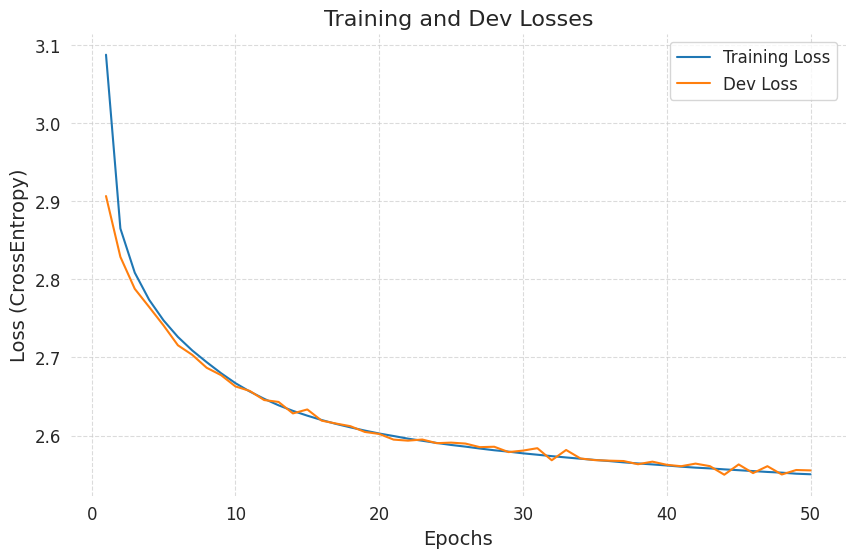

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
sns.set_style("whitegrid")  # Set a visually appealing style with a grid

sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
sns.lineplot(x=epochs, y=dev_losses, label="Dev Loss")


plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss (CrossEntropy)", fontsize=14)
plt.title("Training and Dev Losses", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7) # Customize grid appearance
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True) # Improve aesthetics by removing top/right borders

plt.show()


In [13]:


import torch
import torch.nn.functional as F

def calculate_perplexity(model, dataset):
    """Calculates the perplexity of the model on the given dataset."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataset:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = F.cross_entropy(output, y) # Use cross_entropy directly for perplexity
            total_loss += loss.item() * len(y)  # Scale loss by batch size
    avg_loss = total_loss / len(dataset.dataset)
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

def calculate_character_accuracy(model, dataset):
    """Calculates character-level accuracy."""
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for X, y in dataset:
            X, y = X.to(device), y.to(device)
            output = model(X)
            predictions = torch.argmax(output, dim=1)
            correct_predictions += (predictions == y).sum().item()
            total_predictions += len(y)
    accuracy = correct_predictions / total_predictions
    return accuracy


# Example usage:
perplexity = calculate_perplexity(model, validation_dataset)
accuracy = calculate_character_accuracy(model, validation_dataset)

print(f"Perplexity on validation set: {perplexity}")
print(f"Character Accuracy on validation set: {accuracy}")


Perplexity on validation set: 12.803561210632324
Character Accuracy on validation set: 0.22407398370016104


In [36]:
prefix = "an"  # Specify the desired prefix
model.generate_names_starting_with(prefix)

['an', 'an', 'an', 'an', 'an', 'an', 'an', 'an', 'an', 'an']